In [1]:
import zipfile
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras import layers
from keras.regularizers import l2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, concatenate
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
import pylab as pl
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import load_model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import preprocessing
import itertools
import math
from keras.layers.recurrent import LSTM

# audio lib
import librosa
import librosa.display
from librosa.util import fix_length

import IPython.display as ipd
from PIL import Image


In [2]:
import warnings
warnings.filterwarnings("ignore")

# CNN MEL SPECTROGRAM APPROACH - MERGED DATASET

Una volta capito che il modello migliore era quello ottenuto tramite CNN sono stati generati spectrogrammi di Mel corrispondenti i dataset: "PMEmo", "4Q", "Emotify".
Al fine di ottenere un dataset finale più bilanciato del dataset "PMEmo" sono stati presi solo 600 campioni.

In [3]:
df1 = pd.read_csv('../input/mel-pmemo/mel.csv')
df2 = pd.read_csv('../input/mel-4q/mel.csv')
df3 = pd.read_csv('../input/mel-emotify/mel.csv')

df1['ID_song'] = df1['ID'].astype(str).str[0:4]
df2['ID_song'] = df2['ID'].astype(str).str[0:4]
df3['ID_song'] = df3['ID'].astype(str).str[0:4]

df1_ID = pd.DataFrame()
df1_ID['ID_song'] = df1['ID_song'].drop_duplicates()

df2_ID = pd.DataFrame()
df2_ID['ID_song'] = df2['ID_song'].drop_duplicates()

df3_ID = pd.DataFrame()
df3_ID['ID_song'] = df3['ID_song'].drop_duplicates()


df1_ID

,ID_song
0,3001
5,3004
10,3005
15,3006
20,3007
...,...
3718,3993
3723,3996
3728,3997
3733,3999


In [4]:
df_ID = pd.concat([df1_ID[:150], df2_ID, df3_ID[:150]], ignore_index=True, sort=False)
df = pd.concat([df1, df2, df3], ignore_index=True, sort=False)

print(df_ID.shape)
print(df.shape)


(1200, 1)
(9844, 3)


In [5]:
for i in np.array(df_ID['ID_song']):
    miss = False
    
    if (i + '-0') not in df['ID'].values:
        miss = True
    if (i + '-1') not in df['ID'].values:
        miss = True
    if (i + '-2') not in df['ID'].values:
        miss = True
    if (i + '-3') not in df['ID'].values:
        miss = True
    if miss:
        df_ID = df_ID[df_ID.ID_song != i] # riga con solo un'immagine
        print("Rimosso ID: " +i)

Rimosso ID: 3069
Rimosso ID: 3084
Rimosso ID: 1678
Rimosso ID: 1687
Rimosso ID: 2040
Rimosso ID: 2066
Rimosso ID: 2073


In [6]:
ID_train, ID_test = train_test_split( np.array(df_ID['ID_song']), test_size=0.30, shuffle = True,  random_state=1)
ID_test, ID_validation = train_test_split( ID_test, test_size=0.5, shuffle = True,  random_state=1)

print(ID_train.shape)
print(ID_test.shape)
print(ID_validation.shape)
ID_test

(835,)
(179,)
(179,)


array(['3093', '3043', '1442', '1688', '1730', '3167', '1064', '1108',
       '1671', '1243', '1018', '1174', '1317', '3058', '1503', '1778',
       '1814', '1617', '1465', '1865', '1670', '1365', '1120', '1628',
       '1732', '2053', '1781', '1420', '1267', '1176', '1033', '1057',
       '1831', '1068', '3168', '1625', '3099', '1672', '1555', '1225',
       '1833', '2133', '2039', '1374', '1478', '3097', '1425', '2096',
       '3073', '1681', '1333', '1246', '1305', '1335', '1638', '1531',
       '3014', '1286', '1822', '3134', '1589', '2135', '1633', '2124',
       '3025', '1202', '1437', '3149', '1614', '1431', '1699', '1773',
       '1345', '1650', '1127', '1184', '1198', '3105', '1042', '3100',
       '3009', '1808', '1583', '1758', '1079', '1646', '3006', '1324',
       '1835', '1053', '1810', '1336', '1200', '1183', '3051', '1348',
       '1325', '1677', '2018', '3072', '1775', '1669', '1012', '1839',
       '1723', '1506', '1466', '1706', '1485', '1497', '1384', '3017',
      

In [7]:
y_train_ID = []
y_test_ID = []
y_validation_ID = []

for i in ID_train:
    if (i + '-0') in df['ID'].values:
        y_train_ID.append(i + '-0')
    if (i + '-1') in df['ID'].values:
        y_train_ID.append(i + '-1')
    if (i + '-2') in df['ID'].values:
        y_train_ID.append(i + '-2')
    if (i + '-3') in df['ID'].values:
        y_train_ID.append(i + '-3')


for i in ID_test:
    if (i + '-0') in df['ID'].values:
        y_test_ID.append(i + '-0')
    if (i + '-1') in df['ID'].values:
        y_test_ID.append(i + '-1')
    if (i + '-2') in df['ID'].values:
        y_test_ID.append(i + '-2')
    if (i + '-3') in df['ID'].values:
        y_test_ID.append(i + '-3')

        
for i in ID_validation:
    if (i + '-0') in df['ID'].values:
        y_validation_ID.append(i + '-0')
    if (i + '-1') in df['ID'].values:
        y_validation_ID.append(i + '-1')
    if (i + '-2') in df['ID'].values:
        y_validation_ID.append(i + '-2')
    if (i + '-3') in df['ID'].values:
        y_validation_ID.append(i + '-3')

        
y_train_ID = np.array(y_train_ID)
y_test_ID = np.array(y_test_ID)
y_validation_ID = np.array(y_validation_ID)

print(y_train_ID.shape)
print(y_test_ID.shape)
print(y_validation_ID.shape)
y_test_ID[:100]

(3340,)
(716,)
(716,)


array(['3093-0', '3093-1', '3093-2', '3093-3', '3043-0', '3043-1',
       '3043-2', '3043-3', '1442-0', '1442-1', '1442-2', '1442-3',
       '1688-0', '1688-1', '1688-2', '1688-3', '1730-0', '1730-1',
       '1730-2', '1730-3', '3167-0', '3167-1', '3167-2', '3167-3',
       '1064-0', '1064-1', '1064-2', '1064-3', '1108-0', '1108-1',
       '1108-2', '1108-3', '1671-0', '1671-1', '1671-2', '1671-3',
       '1243-0', '1243-1', '1243-2', '1243-3', '1018-0', '1018-1',
       '1018-2', '1018-3', '1174-0', '1174-1', '1174-2', '1174-3',
       '1317-0', '1317-1', '1317-2', '1317-3', '3058-0', '3058-1',
       '3058-2', '3058-3', '1503-0', '1503-1', '1503-2', '1503-3',
       '1778-0', '1778-1', '1778-2', '1778-3', '1814-0', '1814-1',
       '1814-2', '1814-3', '1617-0', '1617-1', '1617-2', '1617-3',
       '1465-0', '1465-1', '1465-2', '1465-3', '1865-0', '1865-1',
       '1865-2', '1865-3', '1670-0', '1670-1', '1670-2', '1670-3',
       '1365-0', '1365-1', '1365-2', '1365-3', '1120-0', '1120

In [8]:
path1 = '../input/mel-pmemo/melspectrogram_dataset/'
path2 = '../input/mel-4q/melspectrogram_dataset/'
path3 = '../input/mel-emotify/melspectrogram_dataset/'


# Load the images and the labels
x_train = []
x_test = []
x_validation = []

for img in y_train_ID:
    if img[0] == '3':
        pic = image.load_img((path1 + img + '.png'))
        x_train.append(np.array(pic))
    elif img[0] == '1':
        pic = image.load_img((path2 + img + '.png'))
        x_train.append(np.array(pic))
    elif img[0] == '2':
        pic = image.load_img((path3 + img + '.png'))
        x_train.append(np.array(pic))

for img in y_test_ID:
    if img[0] == '3':
        pic = image.load_img((path1 + img + '.png'))
        x_test.append(np.array(pic))
    elif img[0] == '1':
        pic = image.load_img((path2 + img + '.png'))
        x_test.append(np.array(pic))
    elif img[0] == '2':
        pic = image.load_img((path3 + img + '.png'))
        x_test.append(np.array(pic))
        
for img in y_validation_ID:
    if img[0] == '3':
        pic = image.load_img((path1 + img + '.png'))
        x_validation.append(np.array(pic))
    elif img[0] == '1':
        pic = image.load_img((path2 + img + '.png'))
        x_validation.append(np.array(pic))
    elif img[0] == '2':
        pic = image.load_img((path3 + img + '.png'))
        x_validation.append(np.array(pic))
    
x_train = np.array(x_train)
x_test = np.array(x_test)
x_validation = np.array(x_validation)

print(x_train.shape)
print(x_test.shape)
print(x_validation.shape)

(3340, 300, 300, 3)
(716, 300, 300, 3)
(716, 300, 300, 3)


In [9]:
y_train = []
y_test = []
y_validation = []

for i in ID_train:
    
    row = df.loc[df['ID'] == (i + '-0')]
    y_train.append(row['Label'].iloc[0])

for i in ID_test:
    
    row = df.loc[df['ID'] == (i + '-0')]
    y_test.append(row['Label'].iloc[0])


for i in ID_validation:
    
    row = df.loc[df['ID'] == (i + '-0')]
    y_validation.append(row['Label'].iloc[0])
    
    
    
y_train = np.array(y_train)
y_test = np.array(y_test)
y_validation = np.array(y_validation)

print(y_train.shape)
print(y_test.shape)
print(y_validation.shape)

(835,)
(179,)
(179,)


Si procede a costruire il modello della rete ricorrente.
si utilizzano i seguenti iperparametri:


*   Tipo di modello: LSTM
*   Modello di partenza: MobileNetV3
*   Numero di epoche 20;
*   Activation Output Layer Softmax: funzione più usata per la classificazione multiclasse;
*   Activation Hidden Layer ReLU: è la funzione di "deafult" grazie alla sua versatilità per la maggior parte degli utilizzi;
*   Loss Function Sparse Categorical Crossentropy: funzione usata nella classificazione multiclasse usando varibili categoriche;
*   Optimizer RMSprop;
*   Regolarizzazione tramite dropout.
*   Per evitare overfitting si utilizzeranno i pesi che ottengono il miglior valore di loss sul validation set.

In [10]:
# Load a pre-trained neural network to use for feature extractor
base_net = load_model('../input/effnetb3spectrogram/weights.cnn.hdf5')

2022-07-19 15:54:50.059526: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 15:54:50.194200: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 15:54:50.195073: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 15:54:50.196482: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [11]:
layer_name = 'flatten'
feature_extractor = Model(inputs=base_net.input, outputs=base_net.get_layer(layer_name).output)

In [12]:
feature_train = feature_extractor.predict(x_train, verbose=1)
feature_test = feature_extractor.predict(x_test, verbose=1)
feature_val = feature_extractor.predict(x_validation, verbose=1)

2022-07-19 15:54:55.965961: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 901800000 exceeds 10% of free system memory.
2022-07-19 15:54:56.909006: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 901800000 exceeds 10% of free system memory.
2022-07-19 15:54:57.662737: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-19 15:54:59.660460: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


23/23 [==============================] - 1s 35ms/step


In [13]:
print(feature_train.shape)
print(feature_test.shape)
print(feature_val.shape)

(3340, 1280)
(716, 1280)
(716, 1280)


In [14]:
reshaped_train = np.reshape(feature_train, (int(feature_train.shape[0] / 4), 4, -1))
print(reshaped_train.shape)

reshaped_test = np.reshape(feature_test, (int(feature_test.shape[0] / 4), 4, -1))
print(reshaped_test.shape)

reshaped_val = np.reshape(feature_val, (int(feature_val.shape[0] / 4), 4, -1))
print(reshaped_val.shape)

(835, 4, 1280)
(179, 4, 1280)
(179, 4, 1280)


In [15]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape= reshaped_train.shape[1:]))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))


model.compile(loss='sparse_categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])



In [16]:
filepath_cnn="weights.cnn.hdf5"
checkpoint = ModelCheckpoint(filepath_cnn, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [17]:
hist_lstm = model.fit(reshaped_train, y_train, batch_size=32, epochs=20, validation_data=(reshaped_val, y_validation), callbacks=[checkpoint])

Epoch 1/20
27/27 [==============================] - 3s 33ms/step - loss: 2.8393 - accuracy: 0.8395 - val_loss: 0.9253 - val_accuracy: 0.9218

Epoch 00001: val_accuracy improved from -inf to 0.92179, saving model to weights.cnn.hdf5
Epoch 2/20
27/27 [==============================] - 1s 22ms/step - loss: 1.0587 - accuracy: 0.8874 - val_loss: 1.0492 - val_accuracy: 0.9106

Epoch 00002: val_accuracy did not improve from 0.92179
Epoch 3/20
27/27 [==============================] - 1s 22ms/step - loss: 0.8123 - accuracy: 0.8826 - val_loss: 0.9299 - val_accuracy: 0.9050

Epoch 00003: val_accuracy did not improve from 0.92179
Epoch 4/20
27/27 [==============================] - 1s 21ms/step - loss: 0.6370 - accuracy: 0.9030 - val_loss: 0.8261 - val_accuracy: 0.9106

Epoch 00004: val_accuracy did not improve from 0.92179
Epoch 5/20
27/27 [==============================] - 1s 22ms/step - loss: 0.6307 - accuracy: 0.8982 - val_loss: 1.0366 - val_accuracy: 0.9050

Epoch 00005: val_accuracy did not i

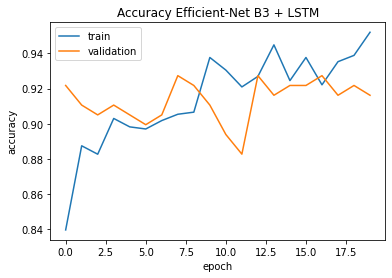

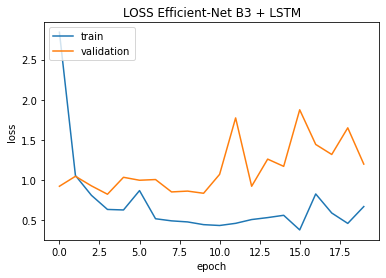

In [18]:
def plot_hist(hist, title):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("Accuracy " + title)
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    
    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title("LOSS " + title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()


plot_hist(hist_lstm, title="Efficient-Net B3 + LSTM")

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Convolutional Neural Network - accuracy: 0.9050279259681702 



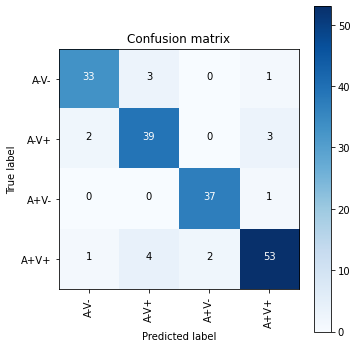

In [20]:
score = model.evaluate(reshaped_test, y_test, verbose=0)
print('Convolutional Neural Network - accuracy:', score[1],"\n")
Y_pred = model.predict(reshaped_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
confusion_mtx = confusion_matrix(y_test, Y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = ['A-V-','A-V+','A+V-','A+V+']) 
plt.show()

In [21]:
print(classification_report(y_test, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90        37
           1       0.85      0.89      0.87        44
           2       0.95      0.97      0.96        38
           3       0.91      0.88      0.90        60

    accuracy                           0.91       179
   macro avg       0.91      0.91      0.91       179
weighted avg       0.91      0.91      0.91       179

